In [1]:
# Installing spacy's English pipeline
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 6.3 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Importing necessary libraries and ignoring warnings to make it more readable
import os
import text_normalizer
import evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize.toktok import ToktokTokenizer
from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np
import warnings
import spacy
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/app/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


---
## 1. Getting the data

#### Downloading the data and process it in order to obtain:

* `X_train:` list with reviews for training.
* `y_train:` list with labels for training.
* `X_test:` list with reviews for testing.
* `y_test:` list with labels for testing.

`Notes:` The target column is `positive`, that way the positive value will be indicated with a value of `1` and negative with a value of `0`. In this case, a split train/test is not necessary because the original data is already separated.

In [3]:
# Dividing the information into the proper sets
data = "../src/movie_reviews_dataset/"
train = os.path.join(data,'train')
y_train = []
X_train = []

print('#####################')
print('\nLoading train data\n')
for label_type in ['neg','pos']:
    dir_n_train = os.path.join(train,label_type) 
    print('Loading ',label_type)
    for fname in os.listdir(dir_n_train):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_n_train,fname), encoding="utf8")
            X_train.append(f.read())
            f.close()
            if label_type == 'neg':
                y_train.append(0)
            else:
                y_train.append(1)
print('\nTrain data loaded\n')
print('#####################')
print('\nLoading test data\n')
test = os.path.join(data,'test')
y_test = []
X_test = []
for label_type in ['neg','pos']:
    dir_n_test = os.path.join(test,label_type) 
    print('Loading ',label_type)
    for fname in os.listdir(dir_n_test):
        if fname[-4:] == ".txt":
            f = open(os.path.join(dir_n_test,fname), encoding="utf8")
            X_test.append(f.read())
            f.close()
            if label_type == 'neg':
                y_test.append(0)
            else:
                y_test.append(1)
print('\nTest data loaded\n')
print('#####################')

#####################

Loading train data

Loading  neg
Loading  pos

Train data loaded

#####################

Loading test data

Loading  neg
Loading  pos

Test data loaded

#####################


We are going to check if the dimensions match.

In [4]:
def check_data(X_train, y_train, X_test, y_test):
    if len(X_train) == len(y_train) == len(X_test) == len(y_test) == 25000:
        print('Reading Data Success!')
    else:
        raise ValueError('Dimensions do not match!')

check_data(X_train, y_train, X_test, y_test)

Reading Data Success!


---
## 2. Normalizing the data

#### The following functions will be created in the python script called `text_normalizer.py` and imported them into the notebook.

#### Respect names and minimal interfaces:

* `remove_html_tags(text):` to remove all HTML tags that may be present in text.
* `remove_accented_chars(text):` to remove accented characters from text
* `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
* `lemmatize_text(text):` to lemmatize text.
* `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
* `remove_special_chars(text):` to remove special characters from text.
* `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
* `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
* `remove_extra_new_lines(text):` to remove extra newlines from text.
* `remove_extra_whitespace(text):` to remove extra whitespaces from text.

To apply each of the functions created and pre-process the dataset, the `normalize_corpus` function of the `text_normalizer.py` script is used. In this method each of the functions is called. In fact what you consider necessary can enabled or disabled, for example: you can lemmatize or apply stemming or directly not apply any of the two and so on with the rest.

In [5]:
# Normalizing the X sets
X_train = text_normalizer.normalize_corpus(X_train)
X_test = text_normalizer.normalize_corpus(X_test)

We are going to check that the pre-processing does what we need it to do, for this we are going to test the functions with predefined inputs and we are going to see if the outputs match what we are looking for.

In [6]:
import nltk

# Inputs
doc_html = """
<br /><br />But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
doc_accented = "Héllo, thís is an accented sénténce."
doc_contractions = "I can't, because it doesn't work."
doc_lemma = "The striped bats are hanging on their feet for best"
doc_stem = """
Where did he learn to dance like that?
His eyes were dancing with humor.
She shook her head and danced away.
"""
doc_specials = "hello? there A-Z-R_T(,**), world, welcome to python. this **should? the next line#followed- by@ an#other %million^ %%like $this."
doc_digits = "abc123def456ghi789zero0 hello my friend number 10"
doc_stop = "He is a very good person"
doc_new_lines = """we
use
a
lot
of
lines"""
doc_spaces = "Hello           my      dear          friend"

# Outputs
good_html = """
But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
good_accented = "Hello, this is an accented sentence."
good_contractions = "I cannot, because it does not work."
good_lemma = "the stripe bat be hang on their foot for good"
good_stem = "where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away ."
good_specials = "hello there AZRT world welcome to python this should the next linefollowed by another million like this"
good_digits = "abcdefghizero hello my friend number "
good_stop = "good person"
good_new_lines = "we use a lot of lines"
good_spaces = "Hello my dear friend"
stop_words = nltk.corpus.stopwords.words('english')

def check_normalization():
    if good_html == text_normalizer.remove_html_tags(doc_html):
        print('[1/10] Remove HTML Success!')
    else:
        raise ValueError('[1/10] Remove HTML Fail!')
        
    if good_accented == text_normalizer.remove_accented_chars(doc_accented):
        print('[2/10] Remove Accented Success!')
    else:
        raise ValueError('[2/10] Remove Accented Fail!')
        
    if good_contractions == text_normalizer.expand_contractions(doc_contractions):
        print('[3/10] Expand Contractions Success!')
    else:
        raise ValueError('[3/10] Expand Contractions Fail!')
        
    if good_lemma == text_normalizer.lemmatize_text(doc_lemma):
        print('[4/10] Lemmatization Success!')
    else:
        raise ValueError('[4/10] Lemmatization Fail!')
        
    print(text_normalizer.stem_text(doc_stem))
    if good_stem == text_normalizer.stem_text(doc_stem):
        print('[5/10] Stemming Success!')
    else:
        raise ValueError('[5/10] Stemming Fail!')
        
    if good_specials == text_normalizer.remove_special_chars(doc_specials):
        print('[6/10] Remove Specials Success!')
    else:
        raise ValueError('[6/8] Remove Specials Fail!')
        
    if good_digits == text_normalizer.remove_special_chars(doc_digits, remove_digits=True):
        print('[7/10] Remove Digits Success!')
    else:
        raise ValueError('[7/10] Remove Digits Fail!')
        
    if good_stop == text_normalizer.remove_stopwords(doc_stop, stopwords=stop_words):
        print('[8/10] Remove Stopwords Success!')
    else:
        raise ValueError('[8/10] Remove Stopwords Fail!')
    
    if good_new_lines == text_normalizer.remove_extra_new_lines(doc_new_lines):
        print('[9/10] Remove New Lines Success!')
    else:
        raise ValueError('[9/10] Remove New Lines Fail!')
        
    if good_spaces == text_normalizer.remove_extra_whitespace(doc_spaces):
        print('[10/10] Remove Extra Whitespaces Success!')
    else:
        raise ValueError('[10/10] Remove Extra Whitespaces Fail!')

check_normalization()

[1/10] Remove HTML Success!
[2/10] Remove Accented Success!
[3/10] Expand Contractions Success!
[4/10] Lemmatization Success!
where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away .
[5/10] Stemming Success!
[6/10] Remove Specials Success!
[7/10] Remove Digits Success!
[8/10] Remove Stopwords Success!
[9/10] Remove New Lines Success!
[10/10] Remove Extra Whitespaces Success!


---
## 3. Feature Engineering

In [7]:
# Vectorizing the X sets to train a model later
tfidf = TfidfVectorizer(ngram_range = (1,2))

x_train_vect = tfidf.fit_transform(X_train)
x_test_vect = tfidf.transform(X_test)

---
## 4. Modeling and Performance Evaluation

In [8]:
# Creating a logistic regression model based on multiple grid searches
lr_model = LogisticRegression(C=2, class_weight='balanced', penalty='none', random_state=6, solver='sag')

# Training and predicting the values
lr_model.fit(x_train_vect, y_train)
lr_model_pred = lr_model.predict(x_test_vect)

In [9]:
# Checking the Model Performance metrics
evaluation.get_performance(lr_model_pred, y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.89072
Precision: 0.8894736842105263
Recall: 0.89232
F1 Score: 0.8908945686900959

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  11114   1386
1   1346  11154


(0.89072, 0.8894736842105263, 0.89232, 0.8908945686900959)

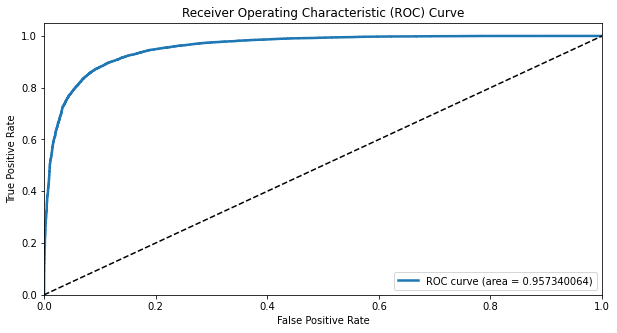

0.957340064

In [10]:
# Calculating the roc auc
roc_auc = evaluation.plot_roc(lr_model, y_test, x_test_vect)
roc_auc

Let's check that the `get_performance` function returns the metrics correctly. For that we are going to simulate input/output data of a model.

In [11]:
def check_basic_metrics():
    accuracy, precision, recall, f1_score = evaluation.get_performance(
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
    )
    
    if (accuracy, precision, recall, f1_score) == (0.6, 0.6, 0.6, 0.6):
        print('Success!')
    else:
        raise ValueError('You must check your get_performance function!')
        
check_basic_metrics()

Model Performance metrics:
------------------------------
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1 Score: 0.6

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10


Prediction Confusion Matrix:
------------------------------
   0  1
0  3  2
1  2  3
Success!


Let's see if the model at least exceeds an ROC-AUC of 0.93

In [12]:
def check_roc(roc_auc):
    if roc_auc > 0.93:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')
        
check_roc(roc_auc)

Success!


---
## 5. Feature Engineering with Custom Word Embedding

### Tokenizing reviews and training my own Word Embedding

For this we are going to use the __gensim__ library with a $vector\_size=100$.

In [13]:
# Tokenizing the X sets to train a model later
tokenizer = ToktokTokenizer()

X_train_tokens = [tokenizer.tokenize(review) for review in X_train]
X_test_tokens = [tokenizer.tokenize(review) for review in X_test]

In [14]:
# Creating a Word2Vec model
model_w2v = Word2Vec(X_train_tokens, vector_size=100, window=5, seed = 1, epochs = 200)

### Generating averaged word vector features

In [15]:
# Creating vectorizer function that will be passed to the tokenized info
def vectorizer(corpus, model, num_features=100):
    '''
    Where:
    * `corpus:` Corresponds to the entire dataset, in this way we obtain an average 
    vector for each review, with a single call to the function.
    * `model:` The trained model.
    * `num_features:` The dimension of the output vector of the embedding 
    (in this case we set this value to 100).
    '''
    vocabulary = set(model.wv.index_to_key)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    corpus_vectors = np.array(features)
    return corpus_vectors  

In [16]:
# Vectorizing the tokenized sets
avg_wv_train_features = vectorizer(corpus=X_train_tokens, model=model_w2v)
avg_wv_test_features = vectorizer(corpus=X_test_tokens, model=model_w2v)

Doing a simple check of the embedding that was just trained.

In [17]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.7188853025436401


Now, we are going to check the vectorizer. It must generate an average vector of all the words present in the same review. So we're going to get two vectors of two words and manually average them, then using those two words we'll simulate a tokenized sentence and see that it matches the manual way.

In [18]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model)[0]

    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2v)

Success!


### Modeling


In [19]:
# Creating a logistic regression model
lr_word2vec = LogisticRegression(random_state=6, max_iter = 200)

# Training and predicting the values
lr_word2vec = lr_word2vec.fit(avg_wv_train_features, y_train)
lr_word2vec_pred = lr_word2vec.predict(avg_wv_test_features)

In [20]:
# Checking the Model Performance metrics
evaluation.get_performance(lr_word2vec_pred, y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.85704
Precision: 0.8649820085050703
Recall: 0.84616
F1 Score: 0.8554674862504044

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     12500
           1       0.86      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10849   1651
1   1923  10577


(0.85704, 0.8649820085050703, 0.84616, 0.8554674862504044)

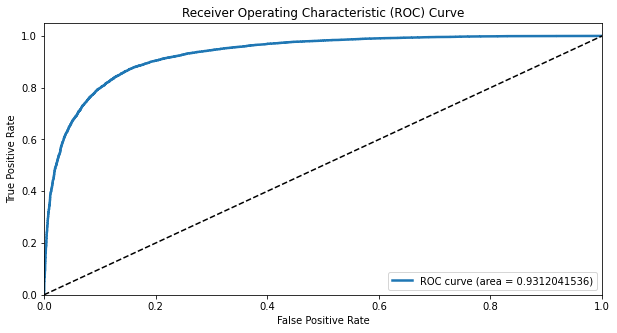

0.9312041536

In [21]:
# Calculating the roc auc
roc_auc = evaluation.plot_roc(lr_word2vec, y_test, avg_wv_test_features)
roc_auc

Checking if the ROC AUC is greater than 0.93

In [22]:
check_roc(roc_auc)

Success!


---
### 6.USING A PRE-TRAINED MODEL

In our case, we train a word embedding from scratch, which is very good at an educational level, but when applying it to a real problem, we need a lot of data (which is not this case). Therefore, in practice, many times we use pre-trained models.

In [23]:
# Loading a Word2Vec pre-trained model
wv_model = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [24]:
# Creating a vectorizer function for the pre-trained model that will be passed to the tokenized info
def vectorizer_2(corpus, wv):
    vectors = []
    for review in corpus:
        words = [word for word in review if word in wv.key_to_index]
        vectors.append(np.array(sum([wv[word] for word in words]) / len(words)))
    return vectors

In [25]:
# Vectorizing the tokenized sets
X_pre_wv_train_feat = vectorizer_2(corpus=X_train_tokens, wv = wv_model)
X_pre_wv_test_feat = vectorizer_2(corpus=X_test_tokens, wv = wv_model)

In [26]:
# Creating a logistic regression model
logreg_word2vec_trained = LogisticRegression(random_state=1, max_iter=600)

# Training and predicting the values
logreg_word2vec_trained = logreg_word2vec_trained.fit(X_pre_wv_train_feat, y_train)
logreg_word2vec_trained_pred = logreg_word2vec_trained.predict(X_pre_wv_test_feat)

In [27]:
# Checking the Model Performance metrics
evaluation.get_performance(logreg_word2vec_trained_pred, y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.80952
Precision: 0.8136857467163937
Recall: 0.80288
F1 Score: 0.8082467584762826

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.81      0.82      0.81     12500
           1       0.81      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10202   2298
1   2464  10036


(0.80952, 0.8136857467163937, 0.80288, 0.8082467584762826)

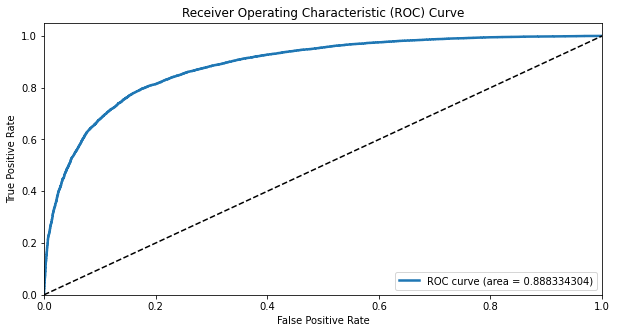

0.888334304

In [28]:
# Calculating the roc auc
roc_auc = evaluation.plot_roc(logreg_word2vec_trained, y_test, X_pre_wv_test_feat)
roc_auc

The pre-trained Word2Vec model doesn't perform better than the previous Word2Vec model (the latter has a higher roc auc value, +0.0428698496)